# Notebook con il rescale dei dati tra [0,1] e rete neurale

* Impostazione per uso della GPU

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from tensorflow import keras
from keras import layers
print("TensorFlow version:", tf.__version__)

import numpy as np
print('Numpy version:', np.__version__)

from matplotlib import pyplot as plt 

TensorFlow version: 2.8.0
Numpy version: 1.21.5


In [ ]:
cd drive/MyDrive/Colab\ Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [ ]:
%ls

 2LS/                              'Lezione GPU.ipynb'
 BlazarDNN.ipynb                    Librerie.ipynb
 BlazarDNN_vecchio.ipynb            model_v2/
 blazar_model_colab.ipynb           model_v3/
 blazar_model_colab_v2.ipynb        model_v4/
 blazar_model_colab_v3.ipynb        model_v5/
 blazar_model_colab_v5.ipynb        model_v6/
 blazar_model_colab_v6.ipynb        model_voub/
 blazar_model_colab_v7_plot.ipynb   nn_data.npz
'Copia di KerasSimple.ipynb'        nn_data_v2.npz
'Copy of CNN tutorial.ipynb'        nn_data_v3.npz
'Copy of Jet_exploration.ipynb'     nn_data_voub.npz
 k_model_pot.py                     __pycache__/


* Final preprocessing dei dati

Correzioni fatte tra nn_data_v2 e nn_data_v3: tolti NAN e valori di flusso superiori a 10^-6. Di seguito i file che contenevano errori:\
in *_v2 sono settati a 0 mentre in *_v3 è stata tolta la misura.
* Blazar con valori NAN nel file SED da sostituire con 0.\
277: /home/elenagasparri/Documenti/Fisica/esame_cmepda/SED_Builder/sedData_bzcat_name/bzcat_name_18/5BZQJ0635-7516.txt
* AGN con valori NAN nel file SED da sostituire con 0.\
2129: /home/elenagasparri/Documenti/Fisica/esame_cmepda/SED_Builder/agns/agns_qrx_19/0635m7516.txt\
2585: /home/elenagasparri/Documenti/Fisica/esame_cmepda/SED_Builder/agns/agns_qrx_2/0021m1910.txt

In [ ]:
# nn_data.npz archivio con i 2 np.ndarray 'bl_data' (4627, 529, 2) 'agn_data' (4059, 529, 2) e  np.array 'nn_freq_data' (529,)
# nn_data.npz ha i flag nei dati sed a 1 per blazars e a 0 per agn
# nn_data_v2.npz ha i flag a 1 per blazar e agn dove abbiamo misura vera del flusso
#                i label per distinguere tra blazar e agn da costruire a parte
# nn_data_v3.npz è corretto rispetto a *_v2.npz: non ha i nan, non ha flussi negativi e non ha flussi superiori a 10^-6
#nn_data = np.load('nn_data_v2.npz')
nn_data = np.load('nn_data_v3.npz')

bl_data = nn_data['bl_data']
agn_data = nn_data['agn_data']
set_freq = nn_data['nn_freq_data']

In [ ]:
print(bl_data.shape)
print(agn_data.shape)

(4627, 529, 2)
(4059, 529, 2)


In [ ]:
# Verifica che non ci siano valori NAN inaspettati nelle misure di flusso
with np.printoptions(threshold=np.inf):
  nanbl_idx=np.argwhere(np.isnan(bl_data))
  nanagn_idx=np.argwhere(np.isnan(agn_data))
  print('Indici delle sed blazar con NAN: ',nanbl_idx)
  print('Indici delle sed agn con NAN: ',nanagn_idx)

Indici delle sed blazar con NAN:  []
Indici delle sed agn con NAN:  []


In [ ]:
# Dati pronti per essere concatenati

data = np.concatenate((bl_data, agn_data), axis =0)
print(data.shape)

(8686, 529, 2)


Adesso che ho max e min posso riscalare i miei valori di flusso tra 0 e 1

In [ ]:
# funzione per normalizzare dati
ptp=np.ptp(data[:,:,0])
min = np.min(data[:,:,0])
max = np.max(data[:,:,0])
print(min)
print(max)
print(ptp)
data[:,:,0]= (data[:,:,0]-min)/ptp


0.0
1.0121e-08
1.0121e-08


In [ ]:
# Creo le label
label = np.concatenate((np.ones(bl_data.shape[0]),np.zeros(agn_data.shape[0])))

In [ ]:
label.shape

(8686,)

In [ ]:
# Permuto il dataset
permutation = np.random.permutation(data.shape[0])
data=data[permutation]
label=label[permutation]

In [ ]:
# Definisco le dimensione dell'array di Input
ishape=data.shape[1:]

In [ ]:
init = tf.keras.initializers.LecunNormal(5)

model = keras.Sequential()
model.add(keras.Input(shape = ishape)) # input
model.add(keras.layers.Conv1D(filters = 32,kernel_initializer=init, kernel_size = 3, strides=1, padding='same',
    activation=None))
model.add(layers.Activation('tanh'))
model.add(keras.layers.MaxPool1D(pool_size=2, strides=2, padding='valid'))
model.add(keras.layers.Conv1D(filters = 64,kernel_initializer=init, kernel_size = 3, strides=1, padding='same',
    activation=None))
model.add(layers.Activation('tanh'))
model.add(keras.layers.MaxPool1D(pool_size=2, strides=2, padding='valid'))
model.add(keras.layers.Conv1D(filters = 128,kernel_initializer=init, kernel_size = 3, strides=1, padding='same',
    activation=None))
model.add(layers.Activation('tanh'))
model.add(keras.layers.MaxPool1D(pool_size=2, strides=2, padding='valid'))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(152)))
model.add(keras.layers.Dense(76, activation='relu',kernel_initializer=init, use_bias=True))
model.add(keras.layers.Dropout(0.6))
model.add(keras.layers.Dense(38, activation='relu', kernel_initializer=init, use_bias=True))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(1, activation='relu', kernel_initializer=init, use_bias=True))

opt = tf.keras.optimizers.Adadelta(learning_rate=0.001)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary() # stampa modello riga per riga

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 529, 32)           224       
                                                                 
 activation (Activation)     (None, 529, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 264, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 264, 64)           6208      
                                                                 
 activation_1 (Activation)   (None, 264, 64)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 132, 64)          0         
 1D)                                                    

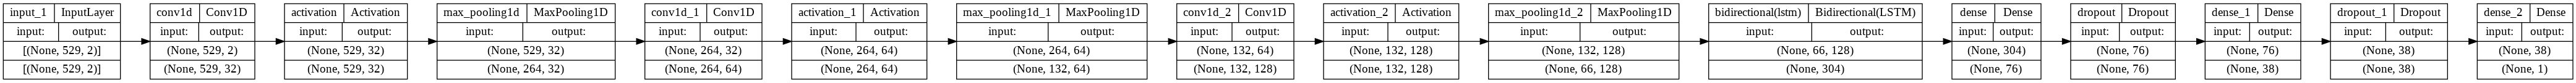

In [ ]:
#from keras.utils import plot_model

keras.utils.plot_model(model, to_file ='model.png',show_shapes=True,rankdir='LR')

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_test, l_train, l_test = train_test_split(data, label, test_size=0.1, random_state=1)


In [ ]:
# split of train dataset in 9 fold: 8 for training, 1 for validation
from sklearn.model_selection import KFold

kf = KFold(n_splits=9, shuffle = True, random_state = 1)

In [ ]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

save_dir = 'model_v6/'
fold_var = 0
history_list = []
for train_idx, val_idx in kf.split(data_train):
  fold_var = fold_var+1
  print(train_idx.shape, val_idx.shape)
  # CREATE CALLBACKS
  checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=4)
  callbacks_list = [checkpoint,earlystopping]
  history=model.fit(x=data_train[train_idx],y=l_train[train_idx],validation_data=(data_train[val_idx],l_train[val_idx]),epochs=20, callbacks=callbacks_list)
  np.save(f'model_v6/my_history_{fold_var}.npy',history.history)
  history_list.append(history)

(6948,) (869,)
Epoch 1/20
218/218 [==============================] - ETA: 0s - loss: 3.9972 - accuracy: 0.4714
Epoch 1: val_accuracy improved from -inf to 0.43613, saving model to model_v6/model_1.h5
218/218 [==============================] - 25s 48ms/step - loss: 3.9972 - accuracy: 0.4714 - val_loss: 4.2139 - val_accuracy: 0.4361
Epoch 2/20
217/218 [============================>.] - ETA: 0s - loss: 3.6296 - accuracy: 0.4712
Epoch 2: val_accuracy did not improve from 0.43613
218/218 [==============================] - 8s 35ms/step - loss: 3.6281 - accuracy: 0.4714 - val_loss: 3.2471 - val_accuracy: 0.4361
Epoch 3/20
217/218 [============================>.] - ETA: 0s - loss: 3.3335 - accuracy: 0.4711
Epoch 3: val_accuracy did not improve from 0.43613
218/218 [==============================] - 8s 35ms/step - loss: 3.3316 - accuracy: 0.4714 - val_loss: 2.9085 - val_accuracy: 0.4361
Epoch 4/20
217/218 [============================>.] - ETA: 0s - loss: 3.1818 - accuracy: 0.4712
Epoch 4: val_

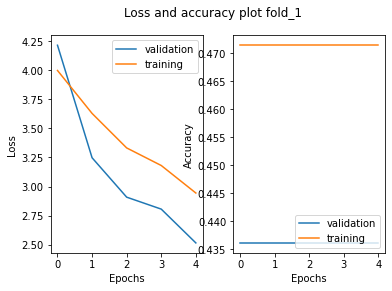

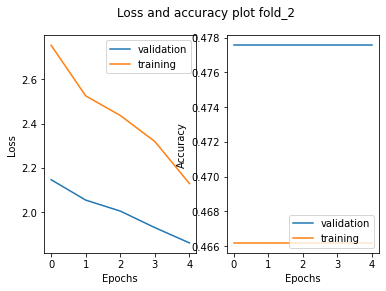

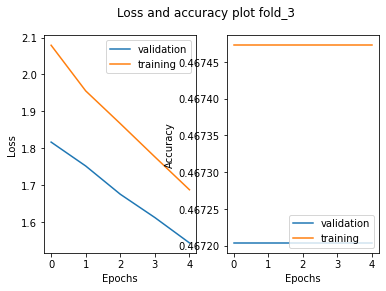

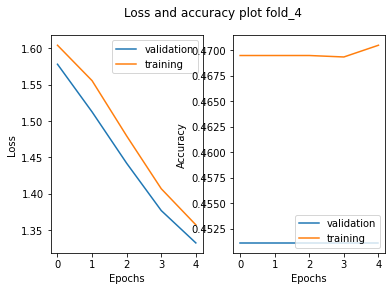

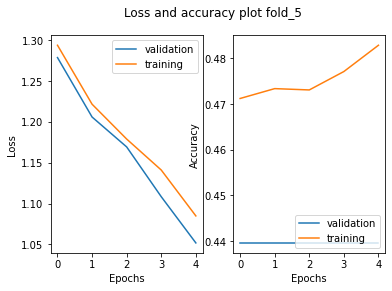

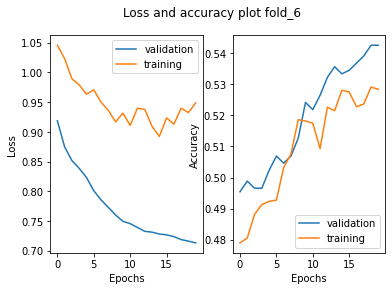

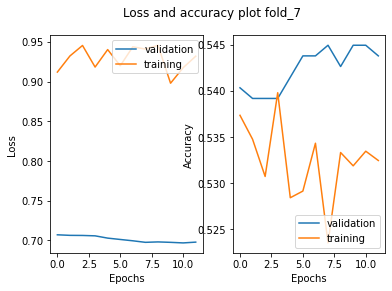

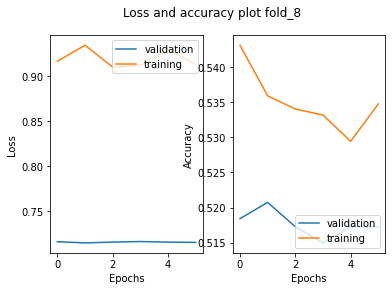

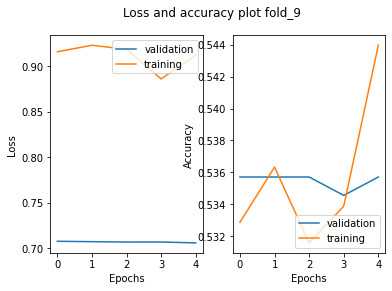

In [ ]:
i = 0
for history in history_list:
  i=i+1
  #print(history.history.keys())
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.suptitle(f'Loss and accuracy plot fold_{i}')

  ax1.plot(history.history["val_loss"], label='validation')
  ax1.plot(history.history["loss"], label='training')
  ax1.legend(loc="upper right")
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  #ax1.set_xlim(-0.5,10)
  #ax1.set_ylim(0.1,0.7)
  
  ax2.plot(history.history["val_accuracy"], label='validation')
  ax2.plot(history.history["accuracy"], label='training')
  ax2.legend(loc="lower right")
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  #ax2.set_xlim(-0.5,10)
  #ax2.set_ylim(0.5,0.9)
  fig.savefig(f'model_v6/plot_{i}')
  fig.show()

In [ ]:
# loading a history with np
# history=np.load('my_history.npy',allow_pickle='TRUE').item()

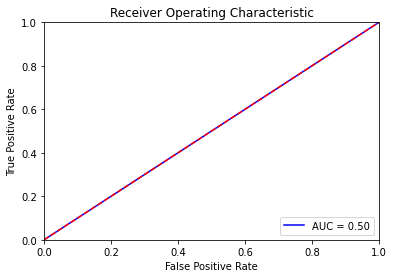

In [ ]:
# ROC Curve and AUC value with error
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict(data_test)
y_preds_probs = np.argmax(probs,axis=1)
fpr, tpr, threshold = metrics.roc_curve(l_test, y_preds_probs)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()